# Machine Learning 1 : Programming Assignment

*Armani Rodriguez*

In [27]:
import os
import re

import cv2
import numpy as np
import matplotlib.pyplot as plt
import sklearn.cluster

import keras
from keras import layers
import lightning.pytorch as pl
from torchvision.models import resnet18
from torchvision.models.resnet import ResNet18_Weights
import torch
import torchsummary
from tqdm import tqdm

# Load Data

Load the data from the dataset repository into numpy arrays

In [6]:
# Classes assigned to me
CLASSES = [
    'Apple Granny Smith',
    'Apple Red Delicious',
    'Apple Golden',
    'Hazelnut',
    'Pepino',
    'Rambutan',
    'Cactus fruit',
    'Mangostan',
    'Pomegranate',
    'Redcurrant'
]

TRAINING_DATA_ROOT = 'Fruit-Images-Dataset/Training'
TEST_DATA_ROOT = 'Fruit-Images-Dataset/Test'



def get_all_in_class(root, cls):
    images = []
    for (dirpath, dirnames, _) in os.walk(root):
        # Match class name plus optional space and digit (e.g. 'Apple Golden 1')
        pattern = f'{cls}( \\d)?' 
        for dirname in dirnames:
            if not re.match(pattern, dirname):
                continue
            for image_filename in os.listdir(os.path.join(dirpath, dirname)):
                image = cv2.imread(os.path.join(dirpath, dirname, image_filename))
                images.append(image)
    return images, [cls] * len(images)

def load_data(root):
    images = []
    labels = []
    for cls in CLASSES:
        class_images, class_labels = get_all_in_class(root, cls)
        images.extend(class_images)
        labels.extend(class_labels)
    return np.array(images), np.array(labels)

# Load data
X_train, y_train = load_data(TRAINING_DATA_ROOT)
X_test, y_test = load_data(TEST_DATA_ROOT)

# Label encoding
le = sklearn.preprocessing.LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.transform(y_test)

print(f'X_train shape: {X_train.shape}')
print(f'y_train shape: {y_train.shape}')

print(f'X_test shape: {X_test.shape}')
print(f'y_test shape: {y_test.shape}')

X_train shape: (5655, 100, 100, 3)
y_train shape: (5655,)
X_test shape: (1898, 100, 100, 3)
y_test shape: (1898,)


# SIFT Feature Extraction

a) Plot the keypoints on one image from the training set

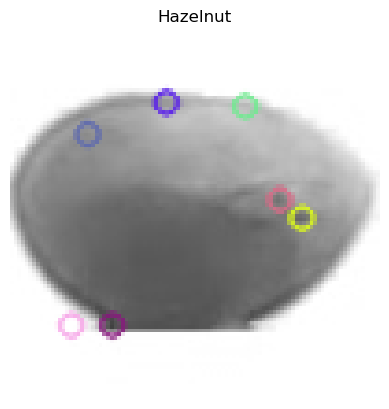

In [7]:
def sift_feature_extraction(image):
    image_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    sift = cv2.SIFT_create()
    kp, des = sift.detectAndCompute(image_gray,None)
    return kp, des

random_index = np.random.randint(0, X_train.shape[0])
random_image = X_train[random_index]
random_label = y_train[random_index]

keypoints, descriptors = sift_feature_extraction(random_image)
image_with_keypoints = cv2.drawKeypoints(cv2.cvtColor(random_image, cv2.COLOR_BGR2GRAY), keypoints, None)

plt.title(le.inverse_transform([random_label]).item())
plt.axis(False)
plt.imshow(image_with_keypoints)

b) Create a new dataset consisting of all keypoints from all images in the training set

In [8]:
KP = []
for img in X_train:
    kp, des = sift_feature_extraction(img)
    KP.extend(des)
KP = np.array(KP)
print(f'KP shape: {KP.shape}')

KP shape: (206282, 128)


c) Perform K-mean clustering such that K = 100 on KP

In [9]:
clustering = sklearn.cluster.KMeans(n_clusters=100, n_init="auto").fit(KP)
print(f'Cluster centers shape: {clustering.cluster_centers_.shape}')

Cluster centers shape: (100, 128)


d) Use the learned K-mean clusters to construct a 100-D vector for each image

In [10]:
def image_to_vector(image):
    _, des = sift_feature_extraction(image)
    labels = clustering.predict(des)
    vector = np.zeros(clustering.n_clusters)
    for label in labels:
        vector[label] += 1
    return vector

print(image_to_vector(random_image))

[0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]


e) Create a new 100-D dataset D consisting of vectors constructed from the training images 

In [11]:
D = np.array([image_to_vector(img) for img in X_train])
print(f'D shape: {D.shape}')

D shape: (5655, 100)


f) Dimensionality reduction (PCA)

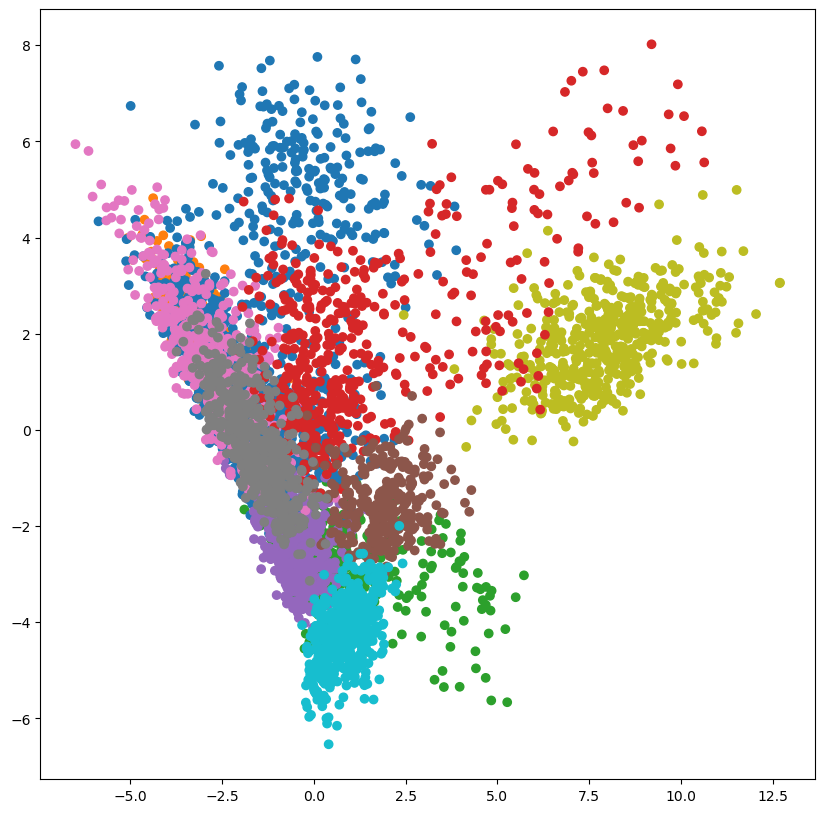

In [12]:
pca = sklearn.decomposition.PCA(n_components=2)
D_2d = pca.fit_transform(D)

plt.figure(figsize=(10, 10))
plt.scatter(D_2d[:, 0], D_2d[:, 1], c=y_train, cmap='tab10')

# Processing Test Set
For each test image:
-   Perform keypoint extraction
-   Use the 100 cluster centers obtained in 3(c) based on training data to obtain a 100D vector for the test image similar to 3(d)

In [13]:
D_test = []

for img in X_test:
    D_test.append(image_to_vector(img))
D_test = np.array(D_test)

print(f'D_test shape: {D_test.shape}')

D_test shape: (1898, 100)


# Support Vector Machine (SVM)

Kernel:  linear
	C: 0.01, Training Error: 0.037842617152962, Test Error: 0.136986301369863
	C: 0.1, Training Error: 0.02139699381078697, Test Error: 0.13277133825079035
	C: 1, Training Error: 0.015561450044208613, Test Error: 0.12592202318229717
	C: 10, Training Error: 0.01432360742705574, Test Error: 0.12434141201264493
	C: 100, Training Error: 0.013085764809902756, Test Error: 0.12961011591148575


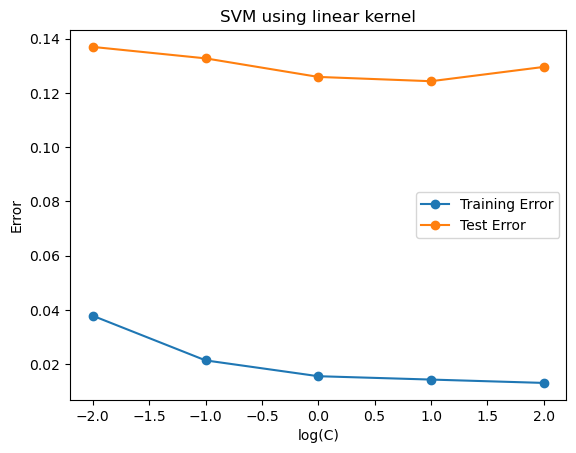

Kernel:  poly
	C: 0.01, Training Error: 0.5138815207780725, Test Error: 0.6338250790305584
	C: 0.1, Training Error: 0.3043324491600353, Test Error: 0.47787144362486833
	C: 1, Training Error: 0.07816091954022986, Test Error: 0.24552160168598525
	C: 10, Training Error: 0.013616268788682606, Test Error: 0.17755532139093788
	C: 100, Training Error: 0.0014146772767462679, Test Error: 0.16069546891464703


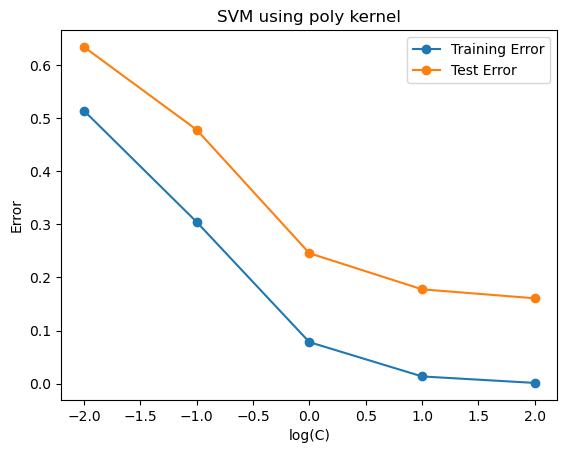

Kernel:  rbf
	C: 0.01, Training Error: 0.5271441202475685, Test Error: 0.5800842992623815
	C: 0.1, Training Error: 0.06808134394341292, Test Error: 0.17123287671232879
	C: 1, Training Error: 0.017683465959328015, Test Error: 0.13013698630136983
	C: 10, Training Error: 0.0014146772767462679, Test Error: 0.12012644889357216
	C: 100, Training Error: 0.0, Test Error: 0.12118018967334032


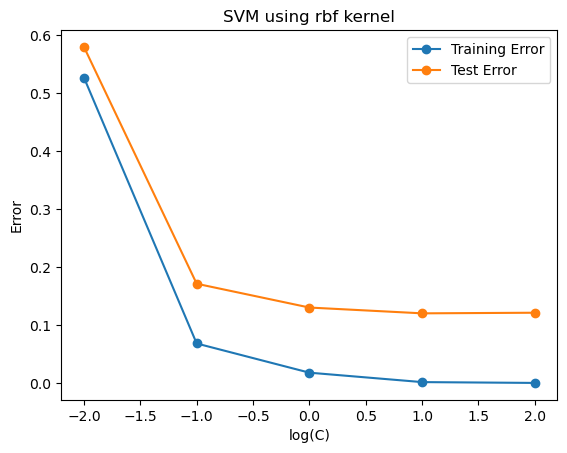

Kernel:  sigmoid
	C: 0.01, Training Error: 0.42175066312997345, Test Error: 0.5189673340358272
	C: 0.1, Training Error: 0.11264367816091958, Test Error: 0.19757639620653322
	C: 1, Training Error: 0.15773651635720598, Test Error: 0.22023182297154897
	C: 10, Training Error: 0.18938992042440317, Test Error: 0.2534246575342466
	C: 100, Training Error: 0.192396109637489, Test Error: 0.2650158061116965


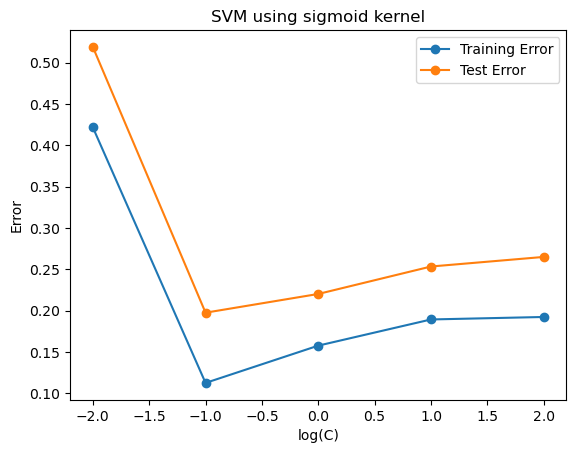

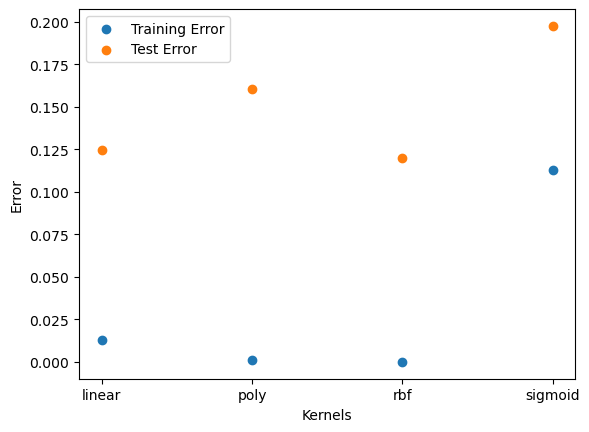

In [36]:
C_choices = [0.01, 0.1, 1, 10 ,100]
kernel_choices = ['linear', 'poly', 'rbf', 'sigmoid']
best_training_errors = []
best_test_errors = []

for kernel in kernel_choices:
    print("Kernel: ", kernel)
    training_errors = []
    test_errors = []
    for C in C_choices:
        model = sklearn.svm.SVC(C=C, kernel=kernel)
        model.fit(D, y_train)
        training_error = 1 - model.score(D, y_train)
        test_error = 1 - model.score(D_test, y_test)
        training_errors.append(training_error)
        test_errors.append(test_error)
        print(f'\tC: {C}, Training Error: {training_error}, Test Error: {test_error}')
    
    plt.title(f'SVM using {kernel} kernel')
    plt.plot(np.log10(C_choices), training_errors, marker='o', label = 'Training Error')
    plt.plot(np.log10(C_choices), test_errors, marker='o', label = 'Test Error')
    plt.xlabel('log(C)')
    plt.ylabel('Error')
    plt.legend()
    plt.show()

    best_training_errors.append(min(training_errors))
    best_test_errors.append(min(test_errors))

plt.scatter(kernel_choices, best_training_errors, label='Training Error')
plt.scatter(kernel_choices, best_test_errors, label='Test Error')
plt.xlabel('Kernels')
plt.ylabel('Error')
plt.legend()
plt.show()

# Convolutional Neural Network

In [15]:
model = keras.Sequential([
    layers.Conv2D(8, (3, 3), activation='relu'),
    layers.Conv2D(8, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(16, activation='relu'),
    layers.Dense(16, activation='relu'),
    layers.Dense(10, activation='softmax')
])
model.build((None, 100, 100, 3))
model.compile(optimizer='adam', 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])
model.summary()
history = model.fit(X_train, keras.utils.to_categorical(y_train), epochs=20, batch_size=16, validation_data=(X_test, keras.utils.to_categorical(y_test)))

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 98, 98, 8)      │           224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 96, 96, 8)      │           584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 48, 48, 8)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 18432)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 16)             │       294,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 16)             │           272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 10)             │           170 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 296,178 (1.13 MB)

 Trainable params: 296,178 (1.13 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
354/354 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - accuracy: 0.4478 - loss: 12.9049 - val_accuracy: 0.8330 - val_loss: 0.9086
Epoch 2/20
354/354 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - accuracy: 0.9615 - loss: 0.3195 - val_accuracy: 0.8583 - val_loss: 0.6307
Epoch 3/20
354/354 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - accuracy: 0.9942 - loss: 0.1567 - val_accuracy: 0.9046 - val_loss: 0.5205
Epoch 4/20
354/354 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - accuracy: 0.9910 - loss: 0.1436 - val_accuracy: 0.8672 - val_loss: 0.5971
Epoch 5/20
354/354 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - accuracy: 0.9960 - loss: 0.0787 - val_accuracy: 0.9110 - val_loss: 0.3628
Epoch 6/20
354/354 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - accuracy: 0.9982 - loss: 0.0491 - val_accuracy: 0.9083 - val_loss: 0.5445
Epoch 7/20
354/354 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - accuracy: 0.9954 - loss: 0.0410 - val_accuracy: 0.8541 - val_loss: 0.5927
Epoch 8/20
354/354 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - accuracy: 0.9916 - loss: 0.0448 - val_acc

a) Plot a graph to show the learning curves

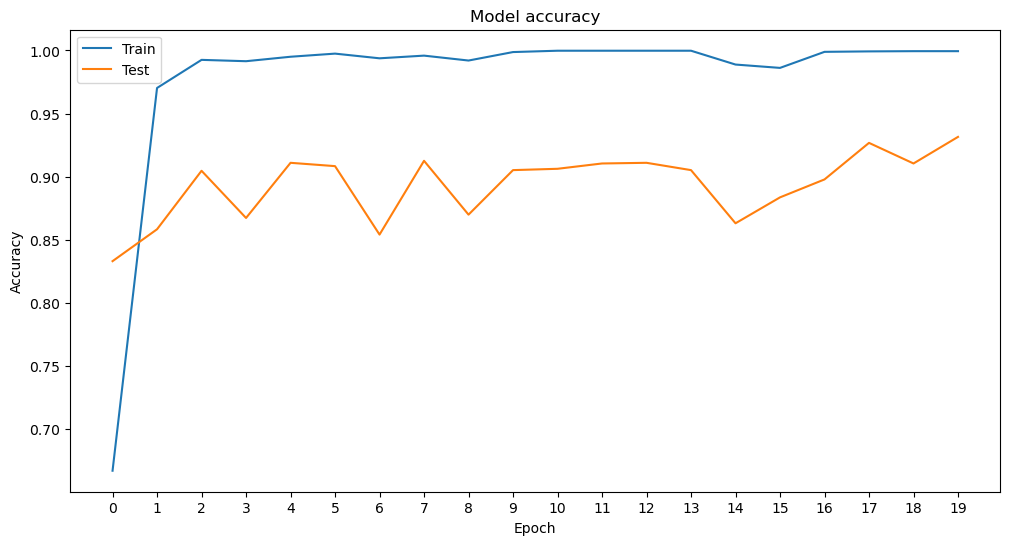

In [16]:
# Plot training & validation accuracy values
plt.figure(figsize=(12, 6))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.xticks(range(0, 20))
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()


# Transfer Learning Via Feature Extraction

**DataLoader configuration and Accuracy callback definition**

In [17]:
# Reshape data to (N, C, H, W)
X_train_torch = X_train.transpose(0, 3, 1, 2)
X_test_torch = X_test.transpose(0, 3, 1, 2)

# Define datasets
train_dataset = torch.utils.data.TensorDataset(torch.tensor(X_train_torch, dtype=torch.float32), torch.tensor(y_train))
test_dataset = torch.utils.data.TensorDataset(torch.tensor(X_test_torch, dtype=torch.float32), torch.tensor(y_test))

# Define dataloaders
train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=16, 
    shuffle=True, 
    num_workers=4,
    persistent_workers=True
)

test_loader = torch.utils.data.DataLoader(
    test_dataset, 
    batch_size=16, 
    shuffle=False, 
    num_workers=4,
    persistent_workers=True
)

class AccuracyCallback(pl.callbacks.Callback):
    """
    Callback that computes and stores the training and validation accuracy at the end of each epoch.
    """
    def __init__(self):
        super().__init__()
        self.training_accuracy = []
        self.validation_accuracy = []

    def on_validation_end(self, trainer, model):
        correct = 0
        total = 0
        for x, y in test_loader:
            x = x.to(model.device)
            y_hat = model(x)
            y_hat = y_hat.detach().cpu()
            correct += torch.sum(torch.argmax(y_hat, dim=1) == y).item()
            total += len(y)
        accuracy = correct / total
        self.validation_accuracy.append(accuracy)

    def on_train_epoch_end(self, trainer, model):
        correct = 0
        total = 0
        for x, y in train_loader:
            x = x.to(model.device)
            y_hat = model(x)
            y_hat = y_hat.detach().cpu()
            correct += torch.sum(torch.argmax(y_hat, dim=1) == y).item()
            total += len(y)
        accuracy = correct / total
        self.training_accuracy.append(accuracy)

**Model Definition**

In [51]:
class ResnetClassifier(pl.LightningModule):
    def __init__(self):
        super().__init__()
        resnet = resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)
        # freeze model
        for param in resnet.parameters():
	        param.requires_grad = False
        # replace output layer
        resnet.fc = torch.nn.Linear(512, 10)
        self.resnet = resnet

    def on_train_start(self):
         self.resnet = self.resnet.to(self.device)

    def forward(self, x):
        return self.resnet(x)
    
    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = torch.nn.functional.cross_entropy(y_hat, y)
        self.log("train_loss", loss, prog_bar=True)
        return loss
    
    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = torch.nn.functional.cross_entropy(y_hat, y)
        self.log("val_loss", loss, prog_bar=True)
        return loss
    
    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=0.001)

ResnetClassifier().resnet



ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

**Training**

In [72]:
EPOCHS=10
resnetClassifierModel = ResnetClassifier()
accuracy = AccuracyCallback()
trainer = pl.Trainer(
    max_epochs=EPOCHS, 
    callbacks=[accuracy],
    num_sanity_val_steps=0
)
trainer.fit(resnetClassifierModel, train_loader, test_loader)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name   | Type   | Params
----------------------------------
0 | resnet | ResNet | 11.2 M
----------------------------------
5.1 K     Trainable params
11.2 M    Non-trainable params
11.2 M    Total params
44.727    Total estimated model params size (MB)


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


**Plot training & validation accuracy curves**

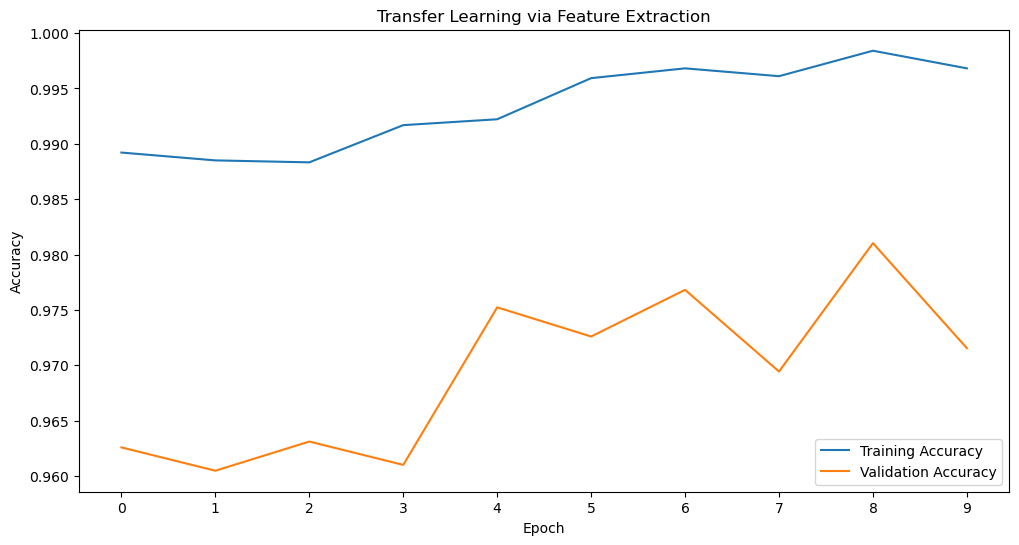

In [73]:
plt.figure(figsize=(12, 6))
plt.plot(accuracy.training_accuracy, label='Training Accuracy')
plt.plot(accuracy.validation_accuracy, label='Validation Accuracy')
plt.title('Transfer Learning via Feature Extraction')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.xticks(range(0, EPOCHS))
plt.legend(loc='lower right')
plt.show()

**Perform feature extraction on the entire dataset**

In [74]:
resnetClassifierModel.eval()
resnetClassifierModel.resnet.avgpool._forward_hooks.clear()
resnetClassifierModel.resnet.layer4[1]._forward_hooks.clear()

X_features_train = []
X_features_test = []

y_features_train = []
y_features_test = []


def training_hook_fn(model, input, output):
    global X_features_train
    output = output.detach().view(output.shape[0], -1).cpu().numpy()
    X_features_train.append(output)
   

def test_hook_fn(model, input, output):
    global X_features_test
    output = output.detach().view(output.shape[0], -1).cpu().numpy()
    X_features_test.append(output)

handle = resnetClassifierModel.resnet.avgpool.register_forward_hook(test_hook_fn)
for x, y in tqdm(test_loader):
    x = x.to(resnetClassifierModel.device)
    resnetClassifierModel(x)
    y_features_test.extend(y.numpy())
handle.remove()


handle = resnetClassifierModel.resnet.avgpool.register_forward_hook(training_hook_fn)
for x, y in tqdm(train_loader):
    x = x.to(resnetClassifierModel.device)
    resnetClassifierModel(x)
    y_features_train.extend(y.numpy())
handle.remove()

X_features_train = np.concatenate(X_features_train, axis=0)
X_features_test = np.concatenate(X_features_test, axis=0)
y_features_train = np.array(y_features_train)
y_features_test = np.array(y_features_test)

print(f'X_features_train shape: {X_features_train.shape}')
print(f'X_features_test shape: {X_features_test.shape}')

print(f'y_features_train shape: {y_features_train.shape}')
print(f'y_features_test shape: {y_features_test.shape}')


100%|██████████| 354/354 [01:32<00:00,  3.83it/s]

X_features_train shape: (5655, 512)
X_features_test shape: (1898, 512)
y_features_train shape: (5655,)
y_features_test shape: (1898,)


**Train SVM on Extracted Features Dataset**

In [78]:
svm = sklearn.svm.SVC(C=10, kernel='rbf')
svm.fit(X_features_train, y_features_train)

training_accuracy = svm.score(X_features_train, y_features_train)
test_accuracy = svm.score(X_features_test, y_features_test)

print(f'Training Accuracy: {training_accuracy}')
print(f'Test Accuracy: {test_accuracy}')

Training Accuracy: 1.0
Test Accuracy: 0.976290832455216


# Transfer Learning via Fine Tuning

In [21]:
class ResnetClassifier2(pl.LightningModule):
    def __init__(self):
        super().__init__()
        resnet = resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)
        resnet.fc = torch.nn.Linear(512, 10)
        self.resnet = resnet

    def on_train_start(self):
         self.resnet = self.resnet.to(self.device)

    def forward(self, x):
        return self.resnet(x)
    
    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = torch.nn.functional.cross_entropy(y_hat, y)
        self.log("train_loss", loss, prog_bar=True)
        return loss
    
    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = torch.nn.functional.cross_entropy(y_hat, y)
        self.log("val_loss", loss, prog_bar=True)
        return loss
    
    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=0.001)

EPOCHS=10
resnetClassifierModel2 = ResnetClassifier2()
accuracy = AccuracyCallback()
trainer = pl.Trainer(
    max_epochs=EPOCHS, 
    callbacks=[accuracy],
    num_sanity_val_steps=0
)
trainer.fit(resnetClassifierModel2, train_loader, test_loader)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name   | Type   | Params
----------------------------------
0 | resnet | ResNet | 11.2 M
----------------------------------
11.2 M    Trainable params
0         Non-trainable params
11.2 M    Total params
44.727    Total estimated model params size (MB)


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


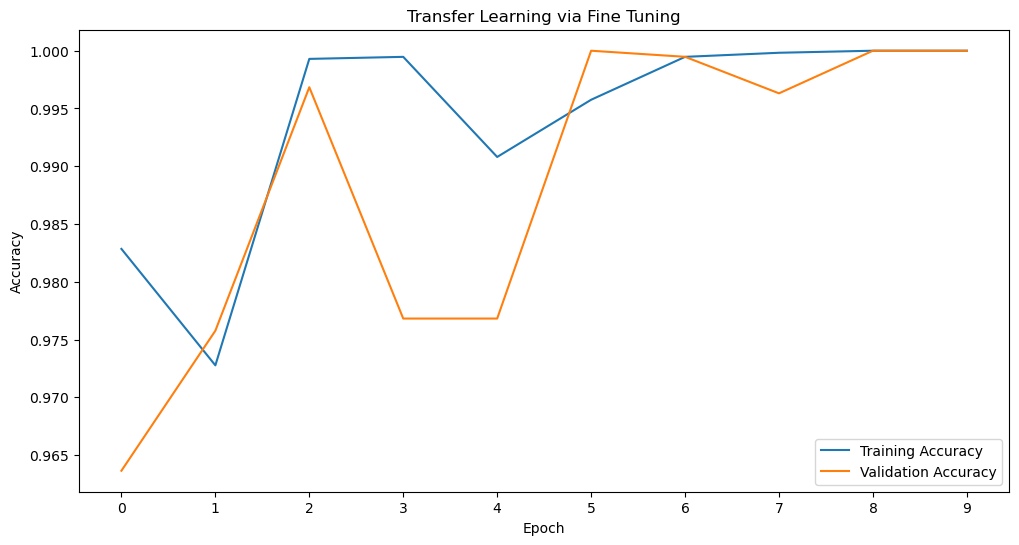

In [44]:
plt.figure(figsize=(12, 6))
plt.plot(accuracy.training_accuracy, label='Training Accuracy')
plt.plot(accuracy.validation_accuracy, label='Validation Accuracy')
plt.title("Transfer Learning via Fine Tuning")
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.xticks(range(0, EPOCHS))
plt.legend(loc='lower right')
plt.show()

# Conclusions:

(a) For 6(a), 7(c), 8(b), what are the test accuracies (identify the epoch from your curves) before
overfitting occurs?
**For 6(a) and 8(b), no overfitting has occured yet because the maximum of the validation accuracy occurs at the final epoch. It is a similar story with**
**7(c) where the test accuracy is still trending upwards at the last epoch.**

(b) For all the approaches you have tried in this assignment, which approach gives you the best test
accuracy/error?
**The best approach was fine tuning resnet18**

(c) Are there any performance result(s) that surprise(s) you? Why?
**The SVM with the radial basis function did much better than I expected, and from now on I will be more thourough when testing different hyperparameters and configurations during model selection**